# Project: Finding Lane Lines on the Road
In this project, a pipeline was created to identify lane lines on the road. Code was developed in following stages 

    > Identify lane lines from provided test images
    > Identify lane lines in a video stream, videos solidWhiteRight.mp4 and solidYellowLeft.mp4 were used for
    validating the performance of the code.
    > Finally code was tested on challenge.mp4

For implementing this project some of the helper functions were used and a few new functions were also written. In the following paragraphs detail the code and implementation

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

## Helper Functions

Below are some helper functions that were used for implementing this project


In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Lane Lines detection in Test Images 
Following  code shall identify the lanes in the images.

## Additional Helper Function
Following list of functions were added

In [3]:
def find_line_param(line_xy):
    """
    This function shall get right lane / left lane start and end points.
    From the start and points slope and constant of the line that fits the two points is calculated

    Arguments: line_xy --> (startpoint_x, startpoint_y, endpoint_x, endpoint_y)

    Result: slope and constant
    """
    # (y2-y1)/(x2-x1)
    slope = (np.int32(np.array(line_xy)[1])-np.int32(np.array(line_xy)[3]))/\
            (np.int32(np.array(line_xy)[0])-np.int32(np.array(line_xy)[2]))
    # c =  y-mx
    constant = np.int32(np.array(line_xy)[1])- slope* np.int32(np.array(line_xy)[0])

    return slope,constant

def identify_left_right_lines(inp_lines=[0,0,0,0]):
    """
    This function shall saperate out the coordinates that correspond to right and left lanes.
    Saperation is done using the fact that a right lane has +ve slope and left has -ve slope.
    This function shall also try to remove horizontal lines if any present.

    Arguments: input_lines = HoughLinesP output
    Result: right_local and left_local lists, they have coordinates of right and left lanes
    
    """
    # Buffers to hold the coordinates
    right_local = []
    left_local = []

    # Loop through the input lines by extracting one line at a time 
    for line in inp_lines:
        for x1,y1,x2,y2 in line:
            # Check if there are any horizontal lines , horizontal lines would have identical y coordinates
            if (abs(y1-y2)>30):
                # Check if x1 = x2  to avoid inifinite slope
                if(x2 is not x1):
                    slope=(y2-y1)/(x2-x1)
                else:
                    slope=(y2-y1)
                
                if slope >0:
                    # +ve Slope means right lane , append the respective buffer.
                    right_local.append((x1,y1))
                    right_local.append((x2,y2))
                else:
                    # -ve Slope means left lane , append the respective buffer.
                    left_local.append((x1,y1))
                    left_local.append((x2,y2))
                
        slope =0

    return (right_local,left_local)
    

def draw_lines(img, lines, dim, color=[255, 0, 0], thickness=10):
    """
    This function shall draw lane lines on the gray image by using HoughLinesP output.
    Since HoughLinesP output is not continuos for each Lane (Left Lane , Right Lane) a
    line is fitted by calculating the slope and constants using the HoughLinesP output

    Arguments:
    img = grayscale image with only region of interest image
    lines = HoughLinesP output
    dim = region of interest coordinates
    color = color of the line
    thickness = thickness of the line
    
    Result:
    line_img = input image + red lane lines    
    """
    # Buffers to hold X,Y coordinates of Right and Left lanes 
    right_xy = []
    left_xy = []
    
    # Blank Image for drawing the lines
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    # Pass input lines to 'identify_left_right_lines' to saperate out left and right lines
    right_xy,left_xy = identify_left_right_lines(lines)
    
    """
    Left Lane: Find the slope and constant from the saperated line coordinates
    For the left lane
         Bottom Point: has minimum x value and maximum y value (y axis is 0 on top)
         Top Point: has maximum x value and min y value (y axis is 0 on top)
    """
    slope,constant = find_line_param([min(np.array(left_xy)[:,0]), max(np.array(left_xy)[:,1]),\
                                      max(np.array(left_xy)[:,0]), min(np.array(left_xy)[:,1])])

    #calculate bottom x (x1) and top x (x2) coordinates x = (y-constant)/slope use the y-coordinates of the region of interest
    # and draw a line in between resultant x1,y1 and x2,y2
    exp_x1 = np.int32((dim[0][0][1]-constant)/slope)
    exp_x2 = np.int32((dim[0][2][1]-constant)/slope)
    cv2.line(line_img, (exp_x1, dim[0][0][1]),(exp_x2, dim[0][2][1]),color, thickness)

    """
    Right Lane: Find the slope and constant from the saperated line coordinates
    For the Right lane
         Bottom Point: has maximum x value and maximum y value (y axis is 0 on top)
         Top Point: has minimum x value and minimum y value (y axis is 0 on top)
    """

    slope,constant = find_line_param([max(np.array(right_xy)[:,0]), max(np.array(right_xy)[:,1]),\
                                      min(np.array(right_xy)[:,0]), min(np.array(right_xy)[:,1])])

    #calculate bottom x (x1) and top x (x2) coordinates x = (y-constant)/slope use the y-coordinates of the region of interest
    #and draw a line in between resultant x1,y1 and x2,y2
    exp_x1 = np.int32((dim[0][0][1]-constant)/slope)
    exp_x2 = np.int32((dim[0][2][1]-constant)/slope)
    cv2.line(line_img, (exp_x1, dim[0][0][1]),(exp_x2, dim[0][2][1]), color, thickness)
       
    return line_img 

In [4]:

def pipeline(image,dim):
    """
    This function accepts two
    Arguments:
           image = raw image
           dim = region of interest coordinates

    Returns:
           img_weighted = processed image with redlines on the raw image

    Description:
    This function acts as a main funtion for image processing and forming the
    the weighted image.

    Raw image shall be converted grayscale and gaussian_blur is applied on it,
    the resultant image is passed through canny edge detection to identify the edges.
    Out of canny edge detection result image that falls in area of interest is extracted and
    passed through HoughLinesP function to identify LaneLines.

    Identified Lane lines are used for drawing lines in red color on the original image.
    Modified image is returned.
    
    """
    # convert the raw image to grayscale and store in img_gray
    img_gray=grayscale(image)

    # apply gaussian blur on the grayscale image to smoothen the image
    img_gray=gaussian_blur(image,5)
    
    # apply canny on the gaussian blur result to identify the edges
    img_gray=canny(img_gray,50,150)
   
    # remove the image that is outside the region of interest.
    img_gray=region_of_interest(img_gray,dim)

    # extract the lanelines from the image
    lines = cv2.HoughLinesP(img_gray, 1, (np.pi/180), 15, np.array([]), 50, 200)

    # draw lines on the gray image by using the lanelines obtained from HoughLinesp
    img_gray=draw_lines(img_gray,lines,dim)

    # draw lines on the raw image
    img_weighted= weighted_img(img_gray,image)
    
    return img_weighted

def process_image(image):
    """
    This function accepts one    
    Argument:
            image = raw image

    returns: 
            processed_image = processed image with redlines on the raw image

    Description:    
    In this function varaible to contain the area of interest are defined.

    Raw image is passed to pipeline function along with the area of interest
    coordinates.

    The result of pipeline function is returned
    """
    # Define variables for four corners of the region of interest
    left_bottom = [120,537]
    left_top= [440,330]
    right_bottom = [890,537]
    right_top = [520,330]

    # create a numpy array 'coordinates'
    coordinates = [np.array( [left_bottom,right_bottom,right_top,left_top], dtype=np.int32 )]

    # send 'image' and 'coordinates' to pipeline function for identifying the lane lines
    # store the result in 'processed_image' variable
    processed_image = pipeline(image,coordinates)
    
    return processed_image

## Main Function (Image)
Following piece of code read the image and passes the read image  to the main function "process_image". Here results of one image are shown rest shall be documented in saperate document

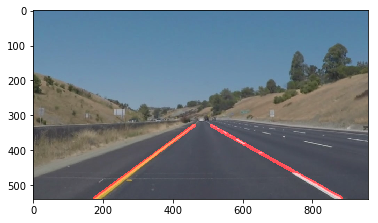

In [5]:
"""
Read the image to 'image' using imread function. Pass the 'image' to process_image function
to identify the lane lines in the image. Show the image returned by the process_image function.
"""
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
plt.imshow(process_image(image))
plt.show()

## Lane Detection in video
Following code shall identify the lanes in the images.

In [6]:
#import package to read and write the video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Additional Functions for Lane Detection in Video
Besides the above functions a few of the below functions were implemented and a few of the previous functions were modified.

In [7]:
def reject_outliers(data, m=2):
    """
    This function is used for removing any points in 'data' buffer that
    deviate a lot from the normal trend. This is done by checking if the distance
    between each point and the mean is more than m* standard deviation.

    Arguments:
    data = input data
    m = acceptable number of times of standard deviation the points could deviate from std

    Results:
    ret_val = array with points with in the standard deviation
    """
    ret_val = []
    match = abs(data - np.mean(data)) < m * np.std(data)
    for idx in range(len(match)):
        if(match[idx]):
            ret_val.append(data[idx])
    return ret_val

def fill_right_lane_buf(lane_xy,out_buf,outbuf_len):
    """
    This function shall recieve start and end coordinates of all the right lines identified
    in this frame. These lines shall be passed to reject_outliers function to remove the points
    that deviate a lot from the trend. After that a single right line shall be identified and
    appened to the output buffer. If the output buffer length increases more than outbuf_len
    then the oldest entry shall be removed, basically a queue.

    Arguments: 
    lane_xy = x,y coordinates of all the identified right lines in the current frame
    out_buf = buffer containing the right lines identified across multiple frames
    outbuf_len = maximum length of the 'out_buf' buffer

    Result:
    out_buf = with updated coordinates
    """
    #convert the lane_xy list to numpy array
    lane_array = np.array(lane_xy)

    # Buffers for temporary x, y coordinate storage
    x_coord = []
    y_coord = []

    # enter the if condition only if the 'lane_array' is not empty
    if lane_array.shape[0]>0 and lane_array.shape[1]>0:

        # remove points that deviate too much from normal trend
        x_coord = reject_outliers(lane_array[:,0])
        y_coord = reject_outliers(lane_array[:,1])

        # check if the resultant buffers are not empty        
        if len(x_coord)>0 and len(y_coord)>0:
            
            # check if out_buf length is more the limit 'outbuf_len' 
            if len(out_buf)<outbuf_len:
                out_buf.append([max(x_coord), max(y_coord),min(x_coord), min(y_coord)])
            else:
                
                # remove the oldest entry to out_buf if the length of out_buf is more than 'outbuf_len'
                out_buf.pop(0)
                out_buf.append([max(x_coord), max(y_coord),min(x_coord), min(y_coord)])
    return out_buf

def fill_left_lane_buf(lane_xy,out_buf,outbuf_len):
    """
    This function shall recieve start and end coordinates of all the left lines identified
    in this frame. These lines shall be passed to reject_outliers function to remove the points
    that deviate a lot from the trend. After that a single left line shall be identified and
    appened to the output buffer. If the output buffer length increases more than outbuf_len
    then the oldest entry shall be removed, basically a queue.

    Arguments: 
    lane_xy = x,y coordinates of all the identified left lines in the current frame
    out_buf = buffer containing the left lines identified across multiple frames
    outbuf_len = maximum length of the 'out_buf' buffer

    Result:
    out_buf = with updated coordinates
    """
    #convert the lane_xy list to numpy array
    lane_array = np.array(lane_xy)

    # Buffers for temporary x, y coordinate storage
    x_coord = []
    y_coord = []

    # enter the if condition only if the 'lane_array' is not empty
    if lane_array.shape[0]>0 and lane_array.shape[1]>0:
        
        # remove points that deviate too much from normal trend
        x_coord = reject_outliers(lane_array[:,0])
        y_coord = reject_outliers(lane_array[:,1])

        # check if the resultant buffers are not empty
        if len(x_coord)>0 and len(y_coord)>0:
            # check if out_buf length is more the limit 'outbuf_len' 
            if len(out_buf)<outbuf_len:
                out_buf.append([min(x_coord), max(y_coord),max(x_coord), min(y_coord)])
            else:
                # remove the oldest entry to out_buf if the length of out_buf is more than 'outbuf_len' 
                out_buf.pop(0)
                out_buf.append([min(x_coord), max(y_coord),max(x_coord), min(y_coord)])
    return out_buf

def find_line_param(line_xy):
    """
    This function shall calculate slope and constant of the line that fits average
    the start and end points across calculated  from multiple frames.

    Arguments: line_xy --> array of lines from multiple frames

    Result: slope and constant
    """
    # (average(y2)-average(y1))/(average(x2)-average(x1))
    slope = (np.int32(np.average(np.array(line_xy)[:,1]))-np.int32(np.average(np.array(line_xy)[:,3])))/\
            (np.int32(np.average(np.array(line_xy)[:,0]))-np.int32(np.average(np.array(line_xy)[:,2])))
    # c =  y-mx
    constant = np.int32(np.average(np.array(line_xy)[:,1]))- slope* np.int32(np.average(np.array(line_xy)[:,0]))

    return slope,constant

#Global variables are created  such that lines from multiple frames could be stored    
global right_lane 
global left_lane
right_lane =[]
left_lane =[]

def draw_lines(img, lines, dim, avg_len=300, color=[255, 0, 0], thickness=10):
    """
    This function shall draw lane lines on the gray image by using HoughLinesP output.

    If the lines identified in each image are directly plotted then huge oscillations
    were observed hence an average filter was implemented. This average filter shall
    operate on last 300 frames line coordinates,here only 2 lines per frames are stored.

    Using the average filter output a line is fitted by calculating the slope and
    constants
    
    Arguments:
    img = grayscale image with only region of interest image
    lines = HoughLinesP output
    dim = region of interest coordinates
    avg_len = decides the number frames data to be considered for averaging
    color = color of the line
    thickness = thickness of the line
    
    Result:
    line_img = input image + red lane lines    
    """
    # Buffers to hold X,Y coordinates of Right and Left lanes indentified across multiple frames
    global right_lane
    global left_lane
    
    # Local Buffers to hold X,Y coordinates of Right and Left lanes 
    right_xy = []
    left_xy = []

    # Blank Image for drawing the lines
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    # Pass input lines to 'identify_left_right_lines' to saperate out left and right lines
    right_xy,left_xy = identify_left_right_lines(lines)

    """
    'fill_right_lane_buf' function shall identify one rightside lane in the current frame
    and store it the in right_lane buffer. For identifying the Right lane following facts are
    considered
    
         Bottom Point: has maximum x value and maximum y value (y axis is 0 on top)
         Top Point: has minimum x value and minimum y value (y axis is 0 on top)
    """
    right_lane = fill_right_lane_buf(right_xy,right_lane,avg_len)
    
    """
    Right Lane: Find the slope and constant from the saperated line coordinates
    and draw the lane
    """
    slope,constant = find_line_param(right_lane)
    exp_x1 = np.int32((dim[0][0][1]-constant)/slope)
    exp_x2 = np.int32((dim[0][2][1]-constant)/slope)
    cv2.line(line_img, (exp_x1, dim[0][0][1]),(exp_x2, dim[0][2][1]), color, thickness)

    """
    'fill_left_lane_buf' function shall identify one leftside lane in the current frame
    and store it the in left_lane buffer. For identifying the left lane following facts are
    considered
    
         Bottom Point: has minimum x value and maximum y value (y axis is 0 on top)
         Top Point: has maximum x value and min y value (y axis is 0 on top)
    """ 
    left_lane=fill_left_lane_buf(left_xy,left_lane,avg_len)

    """
    Left Lane: Find the slope and constant from the saperated line coordinates
    and draw the lane        
    """
    slope,constant = find_line_param(left_lane)
    exp_x1 = np.int32((dim[0][0][1]-constant)/slope)
    exp_x2 = np.int32((dim[0][2][1]-constant)/slope)
    cv2.line(line_img, (exp_x1, dim[0][0][1]),(exp_x2, dim[0][2][1]),color, thickness)
    return line_img    


In [8]:
def pipeline(image,dim):
    """
    This function accepts two
    Arguments:
           image = raw image
           dim = region of interest coordinates

    Returns:
           img_weighted = processed image with redlines on the raw image

    Description:
    This function acts as a main funtion for image processing and forming the
    the weighted image.

    Raw image shall be converted grayscale and gaussian_blur is applied on it,
    the resultant image is passed through canny edge detection to identify the edges.
    Out of canny edge detection result image that falls in area of interest is extracted and
    passed through HoughLinesP function to identify LaneLines.

    Identified Lane lines are used for drawing lines in red color on the original image.
    Modified image is returned.
    
    """
    # convert the raw image to grayscale and store in img_gray
    img_gray=grayscale(image)

    # apply gaussian blur on the grayscale image to smoothen the image
    img_gray=gaussian_blur(img_gray,5)

    # apply canny on the gaussian blur result to identify the edges,
    # min and max thresholds have changed in comparison to image to enhance the performance
    img_gray=canny(img_gray,100,200)

    # remove the image that is outside the region of interest.
    img_gray=region_of_interest(img_gray,dim)

    # extract the lanelines from the image
    lines = cv2.HoughLinesP(img_gray, 1, (np.pi/180), 50, np.array([]), 50, 200)

    # draw lines on the gray image by using the lanelines obtained from HoughLinesp
    img_gray=draw_lines(img_gray,lines,dim)

    # draw lines on the raw image
    img_weighted= weighted_img(img_gray,image)
    return img_weighted

def process_image(image):
    """
    This function accepts one    
    Argument:
            image = raw image

    returns: 
            processed_image = processed image with redlines on the raw image

    Description:    
    In this function varaible to contain the area of interest are defined.

    Raw image is passed to pipeline function along with the area of interest
    coordinates.

    The result of pipeline function is returned
    """
    # Define variables for four corners of the region of interest
    left_bottom = [120,537]
    left_top= [440,330]
    right_bottom = [890,537]
    right_top = [520,330]

    # create a numpy array 'coordinates'
    coordinates = [np.array( [left_bottom,right_bottom,right_top,left_top], dtype=np.int32 )]

    # send 'image' and 'coordinates' to pipeline function for identifying the lane lines
    # store the result in 'processed_image' variable
    processed_image = pipeline(image,coordinates)
    
    return processed_image


## Lane Detection in solidWhiteRight.mp4 file
Following code is the starting point for lane identification.
Video file is opened and then each frame in the video is processed to identify the lanes.

In [9]:
"""
Open the video file to 'cap' then read the Video frame by frame using fl_image function
and pass it to process_image function. Store the resultant processed video in 'modified_clip'
variable. Write out the data into a video in the same folder
"""
right_lane =[]
left_lane =[]
cap = VideoFileClip('test_videos/solidWhiteRight.mp4')
modified_clip = cap.fl_image( process_image )
%time modified_clip.write_videofile("test_videos_output/solidWhiteRight.mp4")

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing audio in solidWhiteRightTEMP_MPY_wvf_snd.mp3


100%|██████████| 195/195 [00:00<00:00, 741.57it/s]

[MoviePy] Done.
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



100%|█████████▉| 221/222 [00:13<00:00, 16.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.34 s, sys: 352 ms, total: 4.69 s
Wall time: 15.5 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos_output/solidWhiteRight.mp4"))

## Lane Detection in solidWhiteRight.mp4 file
Following code is the starting point for lane identification.
Video file is opened and then each frame in the video is processed to identify the lanes.

In [11]:
"""
Open the video file to 'cap' then read the Video frame by frame using fl_image function
and pass it to process_image function. Store the resultant processed video in 'modified_clip'
variable. Write out the data into a video in the same folder
"""
right_lane =[]
left_lane =[]
cap = VideoFileClip('test_videos/solidYellowLeft.mp4')
modified_clip = cap.fl_image( process_image )
%time modified_clip.write_videofile("test_videos_output/solidYellowLeft.mp4")

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing audio in solidYellowLeftTEMP_MPY_wvf_snd.mp3


100%|██████████| 601/601 [00:00<00:00, 989.70it/s] 


[MoviePy] Done.
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:43<00:00, 15.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 14.2 s, sys: 1.08 s, total: 15.3 s
Wall time: 46.6 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos_output/solidYellowLeft.mp4"))

## Lane Detection in challenge.mp4 file
Following code will detect the lanes in challenge.mp4, to do this cannyedge parameters and the region of interest had to be modified.

In [13]:
def pipeline(image,dim):
    """
    This function accepts two
    Arguments:
           image = raw image
           dim = region of interest coordinates

    Returns:
           img_weighted = processed image with redlines on the raw image

    Description:
    This function acts as a main funtion for image processing and forming the
    the weighted image.

    Raw image shall be converted grayscale and gaussian_blur is applied on it,
    the resultant image is passed through canny edge detection to identify the edges.
    Out of canny edge detection result image that falls in area of interest is extracted and
    passed through HoughLinesP function to identify LaneLines.

    Identified Lane lines are used for drawing lines in red color on the original image.
    Modified image is returned.
    
    """
    # convert the raw image to grayscale and store in img_gray
    img_gray=grayscale(image)

    # apply gaussian blur on the grayscale image to smoothen the image
    img_gray=gaussian_blur(img_gray,5)

    # apply canny on the gaussian blur result to identify the edges,
    # min and max thresholds have changed in comparison to image to enhance the performance
    img_gray=canny(img_gray,100,200)

    # remove the image that is outside the region of interest.
    img_gray=region_of_interest(img_gray,dim)

    # extract the lanelines from the image
    lines = cv2.HoughLinesP(img_gray, 1, (np.pi/180), 15, np.array([]), 15, 200)

    # draw lines on the gray image by using the lanelines obtained from HoughLinesp
    img_gray=draw_lines(img_gray,lines,dim)

    # draw lines on the raw image
    img_weighted= weighted_img(img_gray,image)
    return img_weighted

def process_image(image):
    """
    This function accepts one    
    Argument:
            image = raw image

    returns: 
            processed_image = processed image with redlines on the raw image

    Description:    
    In this function varaible to contain the area of interest are defined.

    Raw image is passed to pipeline function along with the area of interest
    coordinates.

    The result of pipeline function is returned
    """
    # Define variables for four corners of the region of interest
   
    left_bottom = [175,675]
    left_top= [600,450]
    right_bottom = [1220,675]
    right_top = [725,450]

    # create a numpy array 'coordinates'
    coordinates = [np.array( [left_bottom,right_bottom,right_top,left_top], dtype=np.int32 )]

    # send 'image' and 'coordinates' to pipeline function for identifying the lane lines
    # store the result in 'processed_image' variable
    processed_image = pipeline(image,coordinates)
    
    return processed_image


In [14]:
"""
Open the video file to 'cap' then read the Video frame by frame using fl_image function
and pass it to process_image function. Store the resultant processed video in 'modified_clip'
variable. Write out the data into a video in the same folder
"""
right_lane =[]
left_lane =[]
cap = VideoFileClip('test_videos/challenge.mp4')
modified_clip = cap.fl_image( process_image )
%time modified_clip.write_videofile("test_videos_output/challenge.mp4")

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing audio in challengeTEMP_MPY_wvf_snd.mp3


100%|██████████| 222/222 [00:00<00:00, 1196.93it/s]

[MoviePy] Done.
[MoviePy] Writing video test_videos_output/challenge.mp4



100%|██████████| 251/251 [00:31<00:00,  7.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 8.27 s, sys: 1.38 s, total: 9.64 s
Wall time: 36.9 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos_output/challenge.mp4"))